<h2>For evaluation of the ensemble we need to create our dataset</h2>

<h2>Connect to the database</h2>

In [1]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

Uninstalling scikit-learn-0.24.2:
  Successfully uninstalled scikit-learn-0.24.2
  Using cached https://files.pythonhosted.org/packages/a8/eb/a48f25c967526b66d5f1fa7a984594f0bf0a5afafa94a8c4dbc317744620/scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl


In [55]:
import psycopg2

db_login = {
    'database': 'basketball',
    'user': 'globetrotter',
    'password': 'alpacaalpaca',
    'host': 'blaskey.dev',
    'port': 5432
}
conn = psycopg2.connect(**db_login)
cur = conn.cursor()

<h2>Get game data and put it in a pandas dataframe</h2>

In [56]:
import pandas as pd 

In [133]:
games = []
cur.execute("SELECT game_id, home_team_id, away_team_id, game_date, " +
            "home_ml, away_ml, home_won_last, away_won_last, home_team_won " + 
            "FROM game WHERE home_ml IS NOT NULL AND " +
            "away_ml IS NOT NULL AND game_date >= '1-1-2018' ORDER BY game_date LIMIT 500")
for i in cur.fetchall():
  games.append([i[0], i[1], i[3], i[4], i[6], True, i[8]])
  games.append([i[0], i[2], i[3], i[5], i[7], False, not i[8]])
df = pd.DataFrame(games, columns = ["GAME_ID", "TEAM_ID", "GAME_DATE", "ML", "WON_LAST", "IS_HOME", "WON"])
df

,GAME_ID,TEAM_ID,GAME_DATE,ML,WON_LAST,IS_HOME,WON
0,21700548,1610612750,2018-01-01,-600,True,True,True
1,21700548,1610612747,2018-01-01,105,False,False,False
2,21700546,1610612761,2018-01-01,-250,True,True,True
3,21700546,1610612749,2018-01-01,200,True,False,False
4,21700552,1610612758,2018-01-02,150,False,True,False
...,...,...,...,...,...,...,...
995,21800405,1610612765,2018-12-12,185,False,False,False
996,21800407,1610612754,2018-12-12,110,True,True,True
997,21800407,1610612749,2018-12-12,-130,True,False,False
998,21800409,1610612764,2018-12-12,150,False,True,False


<h2>Calculate previous game ID for each game</h2>

In [134]:
prev_game_id = []
for i in df.itertuples():
  cur.execute("SELECT game_id FROM game WHERE home_team_id = %s OR " +
              "away_team_id = %s AND game_date < %s ORDER BY game_date DESC LIMIT 1",
              [i[2], i[2], i[3]])
  res = cur.fetchone()
  if res == None:
    prev_game_id.append(None)
  else:
    prev_game_id.append(res[0])
print(prev_game_id)

[22000599, 22000640, 22000634, 22000643, 22000578, 22000602, 22000650, 22000583, 22000644, 22000642, 22000645, 22000649, 22000647, 22000599, 22000166, 22000650, 22000643, 22000617, 22000584, 22000601, 22000621, 22000634, 22000646, 22000651, 22000016, 22000608, 22000642, 22000166, 22000640, 22000602, 22000646, 22000584, 22000645, 22000650, 22000167, 22000599, 22000643, 22000634, 22000583, 22000651, 22000644, 22000608, 22000617, 22000621, 22000649, 22000016, 22000166, 22000643, 22000578, 22000646, 22000647, 22000167, 22000599, 22000601, 22000645, 22000584, 22000578, 22000583, 22000608, 22000646, 22000601, 22000649, 22000621, 22000016, 22000617, 22000643, 22000647, 22000634, 22000640, 22000578, 22000634, 22000645, 22000642, 22000601, 22000650, 22000621, 22000608, 22000644, 22000617, 22000645, 22000166, 22000584, 22000647, 22000649, 22000640, 22000583, 22000578, 22000644, 22000602, 22000584, 22000643, 22000608, 22000599, 22000650, 22000646, 22000642, 22000651, 22000016, 22000583, 22000646,

In [135]:
df["PREV_GAME_ID"] = prev_game_id

In [136]:
df

,GAME_ID,TEAM_ID,GAME_DATE,ML,WON_LAST,IS_HOME,WON,PREV_GAME_ID
0,21700548,1610612750,2018-01-01,-600,True,True,True,22000599
1,21700548,1610612747,2018-01-01,105,False,False,False,22000640
2,21700546,1610612761,2018-01-01,-250,True,True,True,22000634
3,21700546,1610612749,2018-01-01,200,True,False,False,22000643
4,21700552,1610612758,2018-01-02,150,False,True,False,22000578
...,...,...,...,...,...,...,...,...
995,21800405,1610612765,2018-12-12,185,False,False,False,22000649
996,21800407,1610612754,2018-12-12,110,True,True,True,22000617
997,21800407,1610612749,2018-12-12,-130,True,False,False,22000643
998,21800409,1610612764,2018-12-12,150,False,True,False,22000166


<h2>Find stats for the game ID and make our feature vector</h2>

In [137]:
features = []
for i in df.itertuples():
  cur.execute("SELECT SUM(points), " +
              "AVG(field_goals_made) / AVG(field_goals_attempted), " +
              "AVG(free_throws_made) / AVG(free_throws_attempted), " +
              "AVG(three_pointers_made) / AVG(three_pointers_attempted), " +
              "SUM(assists), SUM(offensive_rebounds) + SUM(defensive_rebounds) " +
              "FROM player_game_detail " +
              "WHERE game_id = %s AND team_id = %s", [i[-1], i[2]])
  res = list(cur.fetchone())
  for j in range(len(res)):
    res[j] = float(res[j])

  features.append([int(i[3].strftime("%m")), int(i[3].strftime("%y")) + 2000, # Date stuff
                  i[2]]) # team id
  features[-1].extend(res) # Stats
  features[-1].extend([int(i[6]), # Is home
                      0, 0, # Ignoring tweet things for evaluation 
                      int(i[5])]) # Won last
print(features[:5])

[[1, 2018, 1610612750, 114.0, 0.4931506849315069, 0.7435897435897436, 0.34210526315789475, 24.0, 45.0, 1, 0, 0, 1], [1, 2018, 1610612747, 94.0, 0.41975308641975306, 0.75, 0.3076923076923077, 18.0, 52.0, 0, 0, 0, 0], [1, 2018, 1610612761, 112.0, 0.4819277108433735, 0.7857142857142857, 0.47727272727272724, 31.0, 31.0, 1, 0, 0, 1], [1, 2018, 1610612749, 120.0, 0.4891304347826087, 0.8888888888888888, 0.3684210526315789, 24.0, 49.0, 0, 0, 0, 1], [1, 2018, 1610612758, 125.0, 0.4891304347826087, 0.8571428571428571, 0.3333333333333333, 25.0, 53.0, 1, 0, 0, 0]]


<h2>Transform our feature vector</h2>

In [138]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler

In [139]:
import pickle

f = open("MinMaxScaler.pkl",'rb')
minMax = pickle.load(f)
f = open("OneHotEncoder.pkl",'rb')
oneHot = pickle.load(f)

In [140]:
def transform(data):
  vals = []
  for i in oneHot.categories_[0]:
    if i == int(data[0, 2]):
      vals.append(1)
    else:
      vals.append(0)
    oneHotted = np.array(vals).reshape(1, len(vals))

  minMaxed = minMax.transform(
    np.concatenate([data[::, 0:3], data[::, 3:9]], axis = 1)
  )
  return np.concatenate([minMaxed, oneHotted, data[::, 9:]], axis = 1)

transformed = []
for i in features:
  transformed.append(transform(np.array(i).reshape(1, 13).astype(np.float)))
print(transformed[0:2])

[array([[0.        , 0.83333333, 0.44827586, 0.6       , 0.56625156,
        0.70080483, 0.34210526, 0.46511628, 0.45454545, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 1.        ]]), array([[0.        , 0.83333333, 0.34482758, 0.45185185, 0.39943883,
        0.70828471, 0.30769231, 0.3255814 , 0.56060606, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,


<h2>Calculate probalities of winning with our neural network</h2>

In [141]:
from tensorflow import keras

In [142]:
neural_model = keras.models.load_model("neuralNet.h5")


In [143]:
arr = np.array(transformed).reshape(len(transformed), 43)
probs = neural_model.predict(arr)
probs

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


array([[0.454701  ],
       [0.3202271 ],
       [0.73245156],
       [0.5316343 ],
       [0.49978855],
       [0.32921135],
       [0.34532097],
       [0.3742847 ],
       [0.6808609 ],
       [0.37449628],
       [0.64340794],
       [0.3158956 ],
       [0.49320772],
       [0.26812735],
       [0.5878282 ],
       [0.25035238],
       [0.7192677 ],
       [0.49489602],
       [0.7351017 ],
       [0.39583755],
       [0.40297985],
       [0.5748414 ],
       [0.6881708 ],
       [0.37328833],
       [0.7060767 ],
       [0.6833932 ],
       [0.48678598],
       [0.32436287],
       [0.48978204],
       [0.38112745],
       [0.6962235 ],
       [0.54846346],
       [0.64340794],
       [0.25035238],
       [0.7209209 ],
       [0.27917516],
       [0.71426475],
       [0.5748414 ],
       [0.74502   ],
       [0.22204468],
       [0.6732745 ],
       [0.6833932 ],
       [0.53231686],
       [0.25275677],
       [0.505886  ],
       [0.4935033 ],
       [0.5878282 ],
       [0.567

<h2>Let's calculate our accuracy with the neural network alone</h2>

In [144]:
num_correct = 0
for prob, won in zip(probs, df["WON"]):
  if prob[0] > 0.50 and won:
    num_correct += 1
  elif probs[0] < 0.50 and not won:
    num_correct += 1
acc = num_correct / len(probs)
print(acc)

0.822


<h2>Now let's run the betting bot on the dataset</h2>

In [145]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
from collections import deque
import random


In [146]:
!unzip my-checkpoints.zip

Archive:  my-checkpoints.zip
replace my-checkpoints/checkpoint? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace my-checkpoints/my-checkpoints.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [147]:
class Agent:
    def __init__(self, state_size, window_size, data, skip, batch_size, bet_results):
        # Our model works with a sliding window. Essentially we consider
        # the past n betting observations (let's say n = 3 for example). 
        # These are our states. We consider each betting observation to be a state.
        # The stock market considered each day close to be a state. This makes sense
        # intuitively that each game we have an action to make (bet or not bet).
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2

        self.bet_amount = 100
        self.bet_results = bet_results

        # Data is our actual data ie the moneylines.        
        self.data = data
        # Skip is the number of betting observations to advance.
        self.skip = skip
        # Action size is the number of actions we can take (bet or not bet on a game). 
        # Importantly a single game makes two betting observations.
        self.action_size = 2
        # Batch size is the amount of data in each batch
        self.batch_size = batch_size

        # Memory is used is the length of our memory queue
        self.memory = deque(maxlen = 1000)

        # Gamma is the amount of reward we give to future actions                
        self.gamma = 0.95

        # Epsilon is the value in which our model makes a completly random choice.
        # It starts off high and decays over time as our model learns.
        self.epsilon = 0.01 # Start epsilon off small since we are pretrained
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        # Resets and creates a tensorflow session
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()

        # Our tensors defined used in calculating the probality of the actions
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])

        # Our logits used in calculating the probality.
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        # Cost is how we determine how good our model is.
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        # Our optimizer to help train our model
        self.optimizer = tf.train.GradientDescentOptimizer(1e-7).minimize(
            self.cost
        )

        self.sess.run(tf.global_variables_initializer())

    def restore(self):
        saver = tf.train.Saver()        
        saver.restore(self.sess, 'my-checkpoints/my-checkpoints')

        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)
        
    def act(self, state): # Choose an action to take based off our current window.
        if random.random() <= self.epsilon: # epsilon (0.5 default) of the time do a complete random action
            return random.randrange(self.action_size)
        # Otherwise get the maximum value from our model's logits.
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )

    def get_state(self, t): # Get an array of amounts we would get if we bet 
        window_size = self.window_size 
        d = t - window_size 
        
        block = None
        if d >= 0:
          block = self.data[d : t]
        else: # If we are at the start of the data pad it with first values
          block = -d * [0] + self.data[0 : t]
        res = []

        return np.array([block])
    
    def run_model(self, initial_money, money_lines, bet_results):
        # Initialize buy function
        starting_money = initial_money
        bought = []
        self.data = money_lines
        self.bet_results = bet_results

        state = self.get_state(0)
        for t in range(0, len(self.data), self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            # If we choose to bet and we have the money for it, and aren't betting too close to the end of our data.
            if action == 1 and starting_money >= self.bet_amount and t < (len(self.data) - self.half_window):
               starting_money -= self.bet_amount
               if self.bet_results[t]: # Won bet!
                  starting_money += get_return(self.data[t], self.bet_amount)
               bought.append(True)
            else:
              bought.append(False)
            state = next_state


        return bought, starting_money

def get_return(ml, bet_amount): # Returns the profit + bet_amount.
  if ml < 0:
    return (100 / -ml) * bet_amount + bet_amount
  return (ml / 100) * bet_amount + bet_amount


In [148]:
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
model = Agent(state_size = window_size, 
              window_size = window_size, 
              data = df["ML"], 
              skip = skip, 
              batch_size = batch_size,
              bet_results = df["WON"])
model.restore()


INFO:tensorflow:Restoring parameters from my-checkpoints/my-checkpoints


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


<h2>Run the reinforcement model 100 times on the dataset</h2>

We need to do this since the reinforcement model will give us different values for different runs of the model

In [149]:
bets = []
for i in range(100):
  bet_run, _ = model.run_model(1000, list(df["ML"]), list(df["WON"]))
  bets.append(bet_run)
bets[0:2]

[[False,
  False,
  False,
  False,
  False,
  True,
  False,
  True,
  False,
  True,
  False,
  False,
  True,
  False,
  True,
  True,
  False,
  False,
  False,
  True,
  False,
  True,
  False,
  True,
  False,
  False,
  True,
  False,
  False,
  True,
  False,
  False,
  True,
  False,
  False,
  True,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  True,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  True,
  False,
  True,
  False,
  True,
  False,
  True,
  False,
  False,
  False,
  False,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  True,
  False,
  False,
  False,
  True,
  True,
  True,
  Fal

<h2>Now calculate how the neural network did alone, betting bot did alone, ensemble requring both to agree, ensemble requriign one to agree</h2>

In [150]:
def calc_run(reinforce_bets, neural_probs, mls, res):
  neural_alone = 1000
  reinforce_alone = 1000
  both_needed = 1000
  one_needed = 1000

  for bet, prob, outcome, ml in zip(reinforce_bets, neural_probs, res, mls):
    if prob > 0.5:
      neural_alone -= 100
      if outcome:
        neural_alone += get_return(ml, 100)
    if bet:
      reinforce_alone -= 100
      if outcome:
        reinforce_alone += get_return(ml, 100)
    if prob > 0.5 or bet:
      one_needed -= 100
      if outcome:
        one_needed += get_return(ml, 100)
    if prob > 0.5 and bet:
      both_needed -= 100
      if outcome:
        both_needed += get_return(ml, 100)
  return neural_alone, reinforce_alone, both_needed, one_needed
print(calc_run(bets[0], probs, list(df["ML"]), list(df["WON"])))

(253.9067303402527, 2192.0409856365864, 1935.891481645111, 510.05623433172536)


<h2>Calculate this on all reinforcment runs</h2>

In [151]:
neural, reinforce, both, one = [], [], [], []
for i in bets:
  res = calc_run(i, probs, list(df["ML"]), list(df["WON"]))
  neural.append(res[0])
  reinforce.append(res[1])
  both.append(res[2])
  one.append(res[3])

<h2>Calculate statistics on each group</h2>


In [152]:
def apply(func_name, fun):
  print("Applying " + func_name)
  print("Neural: " + str(fun(neural)))
  print("Reinforce: " + str(fun(reinforce)))
  print("Both: " + str(fun(both)))
  print("One: " + str(fun(one)))

In [156]:
apply("mean", statistics.mean)

print()

apply("median", statistics.median)

print()

apply("max", max)

print()

apply("min", min)

print()

Applying mean
Neural: 253.9067303402527
Reinforce: 1874.5184626576224
Both: 1796.2790409243316
One: 332.1461520735422

Applying median
Neural: 253.9067303402527
Reinforce: 1884.443583039182
Both: 1811.1884138151086
One: 339.1038533793444

Applying max
Neural: 253.9067303402527
Reinforce: 2487.0409856365854
Both: 2170.891481645112
One: 886.722900998392

Applying min
Neural: 253.9067303402527
Reinforce: 12.892027283378752
Both: 1132.5581483117776
One: -1091.4272238037984



<h2>Plot the runs</h2>

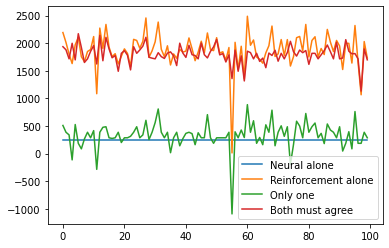

In [163]:
import matplotlib.pyplot as plt

x = list(range(len(neural)))
plt.plot(x, neural, label = "Neural alone")
plt.plot(x, reinforce, label = "Reinforcement alone")
plt.plot(x, one, label = "Only one")
plt.plot(x, both, label = "Both must agree")
plt.legend()

plt.savefig("ensemble.png")

plt.show()
